<a href="https://colab.research.google.com/github/checc1/checc1/blob/main/ErrorMitigationEasy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.9 MB/s eta 0:00:00


In [14]:
!pip install qiskit-ibm-provider

In [12]:
!pip install qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.0 MB/s eta 0:00:00


In [123]:
token = "bQe9fjPKAuBCqc_8PeNw6RUClucye4_TNWU3kYpW5Fpx"
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeBogotaV2, FakeBrisbane

In [124]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

In [125]:
backend = FakeBrisbane()

In [126]:
import numpy as np

In [128]:
def makeCircuit(state: str, backend, shots: int):
  if state == "00":
    qc = QuantumCircuit(2, 2)
    qc.measure(qc.qregs[0], qc.cregs[0])
  elif state == "01":
    qc = QuantumCircuit(2, 2)
    qc.x(1)
    qc.measure(qc.qregs[0], qc.cregs[0])
  elif state == "10":
    qc = QuantumCircuit(2, 2)
    qc.x(0)
    qc.measure(qc.qregs[0], qc.cregs[0])
  elif state == "11":
    qc = QuantumCircuit(2, 2)
    qc.x(0)
    qc.x(1)
    qc.measure(qc.qregs[0], qc.cregs[0])
  else:
    raise ValueError("Invalid state")

  transpiledCirc = transpile(qc, backend=backend)
  job = backend.run(transpiledCirc, shots=shots)
  pub = job.result()
  counts = pub.get_counts()
  return counts


counts00 = makeCircuit("00", backend, 50)
counts01 = makeCircuit("01", backend, 50)
counts10 = makeCircuit("10", backend, 50)
counts11 = makeCircuit("11", backend, 50)

In [148]:
def SummingDict(x: dict):
  ColCounts = {"00": 0, "01": 0, "10": 0, "11": 0}
  for key in x:
    ColCounts[key] += x[key]
  return ColCounts

colCounts00 = SummingDict(counts00)
colCounts01 = SummingDict(counts01)
colCounts10 = SummingDict(counts10)
colCounts11 = SummingDict(counts11)

In [149]:
colCounts00

{'00': 48, '01': 0, '10': 2, '11': 0}

In [150]:
colCounts01

{'00': 0, '01': 0, '10': 50, '11': 0}

In [151]:
M = np.zeros((4, 4))
M[:, 0] = np.array(list(colCounts00.values()))
M[:, 1] = np.array(list(colCounts01.values()))
M[:, 2] = np.array(list(colCounts10.values()))
M[:, 3] = np.array(list(colCounts11.values()))


In [152]:
M = M / 50
M

array([[0.96, 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.98, 0.  ],
       [0.04, 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ]])

In [155]:
qcMyState = QuantumCircuit(2, 2)
qcMyState.h(0)
qcMyState.cx(0, 1)
qcMyState.measure(qcMyState.qregs[0], qcMyState.cregs[0])

transpiledCircMyState = transpile(qcMyState, backend=backend)
jobMyState = backend.run(transpiledCircMyState, shots=50)
pub_resultMyState = jobMyState.result()
counts = pub_resultMyState.get_counts()

In [156]:
counts

{'10': 1, '00': 28, '11': 21}

In [157]:
C_noisy = SummingDict(counts)
C_noisy

{'00': 28, '01': 0, '10': 1, '11': 21}

In [158]:
C_noisy = np.array(list(C_noisy.values()))
C_noisyt = C_noisy.reshape(C_noisy.shape[0], 1)

In [159]:
C_noisyt

array([[28],
       [ 0],
       [ 1],
       [21]])

In [160]:
from scipy import linalg

In [161]:
MtNorm_Inv = linalg.inv(M)
MtNorm_Inv

array([[ 1.04166667e+00, -2.12585034e-02,  0.00000000e+00,
        -0.00000000e+00],
       [-4.16666667e-02,  8.50340136e-04,  1.00000000e+00,
        -0.00000000e+00],
       [ 0.00000000e+00,  1.02040816e+00,  0.00000000e+00,
        -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [165]:
C_mitigated = np.dot(MtNorm_Inv, C_noisyt)
C_mitigated

array([[29.16666667],
       [-0.16666667],
       [ 0.        ],
       [21.        ]])

In [166]:
C_mitigated = np.abs(C_mitigated)

In [173]:
C_mitigated = C_mitigated.reshape(C_mitigated.shape[0])
C_mitigated

array([29.16666667,  0.16666667,  0.        , 21.        ])

In [168]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Mitigated Results')

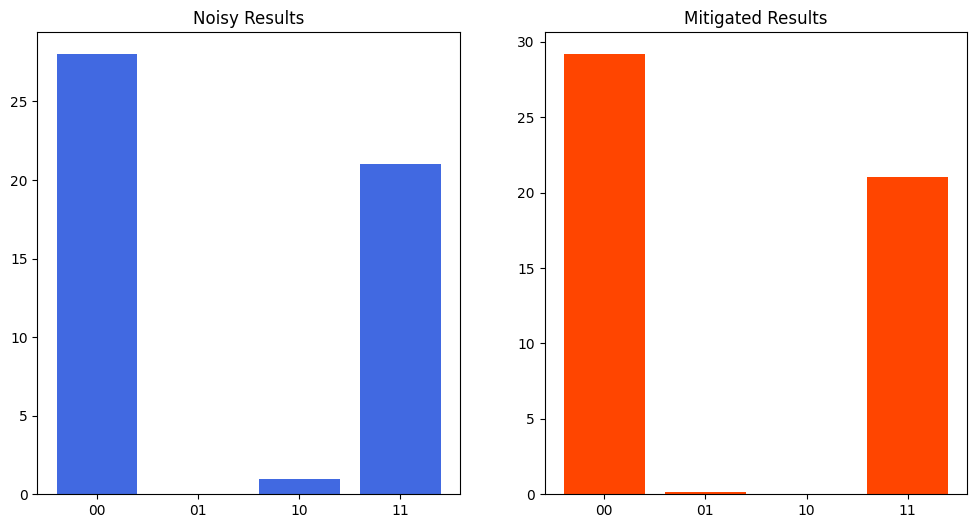

In [174]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
x = range(4)
axs[0].bar(x, C_noisy, color="royalblue")
axs[0].set_xticks(x)
axs[0].set_xticklabels(["00", "01", "10", "11"])
axs[0].set_title("Noisy Results")
axs[1].bar(x, C_mitigated.T, color="orangered")
axs[1].set_xticks(x)
axs[1].set_xticklabels(["00", "01", "10", "11"])
axs[1].set_title("Mitigated Results")

# Quantum walker + Error Mitigation

### we try to apply this simple error mitigation techique to the quantum walker scheme.

In [175]:
from qiskit.circuit.library import QFT

In [184]:
def Binario(x: int):
  return "{0:b}".format(x).zfill(4)

In [185]:
def BinarioStates(posQubits: int):
  N = 2**posQubits
  states = []
  for i in range(N):
    binRep = Binario(i)
    states.append(binRep)
  return states

In [234]:
posQubits = 4
states = BinarioStates(posQubits=posQubits)

In [187]:
states

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

In [190]:
def Generalized_Circuit(bitstring: str, backend, shots: int):
  qc = QuantumCircuit(posQubits, posQubits)
  for i,char in enumerate(list(bitstring)):
    if char == "1":
      qc.x(i)

  qc.measure_all()
  transpiledCirc = transpile(qc, backend=backend)
  job = backend.run(transpiledCirc, shots=shots)
  pub = job.result()
  counts = pub.get_counts()
  return counts

In [204]:
from numpy._core.defchararray import find
def retrieveTrueCounts(x: dict):
  trueValues = list(x.values())
  trueKeys = [list(key)[:4] for key in x.keys()]
  trueKeys = ["".join(key) for key in trueKeys]

  finDict = dict(zip(trueKeys, trueValues))
  return finDict

In [191]:
backend = FakeBrisbane()

stateCounts0000 = Generalized_Circuit("0000", backend, 50)
stateCounts0000

{'0010 0000': 1, '1000 0000': 2, '0100 0000': 2, '0000 0000': 45}

In [205]:
counts0000 = retrieveTrueCounts(stateCounts0000)
counts0000

{'0010': 1, '1000': 2, '0100': 2, '0000': 45}

In [210]:
stateCounts0001 = Generalized_Circuit("0001", backend, 50)
stateCounts0010 = Generalized_Circuit("0010", backend, 50)
stateCounts0011 = Generalized_Circuit("0011", backend, 50)
stateCounts0100 = Generalized_Circuit("0100", backend, 50)
stateCounts0101 = Generalized_Circuit("0101", backend, 50)
stateCounts0110 = Generalized_Circuit("0110", backend, 50)
stateCounts0111 = Generalized_Circuit("0111", backend, 50)
stateCounts1000 = Generalized_Circuit("1000", backend, 50)
stateCounts1001 = Generalized_Circuit("1001", backend, 50)
stateCounts1010 = Generalized_Circuit("1010", backend, 50)
stateCounts1011 = Generalized_Circuit("1011", backend, 50)
stateCounts1100 = Generalized_Circuit("1100", backend, 50)
stateCounts1101 = Generalized_Circuit("1101", backend, 50)
stateCounts1110 = Generalized_Circuit("1110", backend, 50)
stateCounts1111 = Generalized_Circuit("1111", backend, 50)

In [211]:
counts0001 = retrieveTrueCounts(stateCounts0001)
counts0010 = retrieveTrueCounts(stateCounts0010)
counts0011 = retrieveTrueCounts(stateCounts0011)
counts0100 = retrieveTrueCounts(stateCounts0100)
counts0101 = retrieveTrueCounts(stateCounts0101)
counts0110 = retrieveTrueCounts(stateCounts0110)
counts0111 = retrieveTrueCounts(stateCounts0111)
counts1000 = retrieveTrueCounts(stateCounts1000)
counts1001 = retrieveTrueCounts(stateCounts1001)
counts1010 = retrieveTrueCounts(stateCounts1010)
counts1011 = retrieveTrueCounts(stateCounts1011)
counts1100 = retrieveTrueCounts(stateCounts1100)
counts1101 = retrieveTrueCounts(stateCounts1101)
counts1110 = retrieveTrueCounts(stateCounts1110)
counts1111 = retrieveTrueCounts(stateCounts1111)

In [224]:
def SummingDict(x: dict):
  allBits = ["{0:b}".format(i).zfill(4) for i in range(16)]
  values = [0 for i in range(16)]
  ColCounts = dict(zip(allBits, values))
  for key in x:
    ColCounts[key] += x[key]
  return ColCounts

In [225]:
counts0000 = SummingDict(counts0000)
counts0001 = SummingDict(counts0001)
counts0010 = SummingDict(counts0010)
counts0011 = SummingDict(counts0011)
counts0100 = SummingDict(counts0100)
counts0101 = SummingDict(counts0101)
counts0110 = SummingDict(counts0110)
counts0111 = SummingDict(counts0111)
counts1000 = SummingDict(counts1000)
counts1001 = SummingDict(counts1001)
counts1010 = SummingDict(counts1010)
counts1011 = SummingDict(counts1011)
counts1100 = SummingDict(counts1100)
counts1101 = SummingDict(counts1101)
counts1110 = SummingDict(counts1110)
counts1111 = SummingDict(counts1111)

# Get the Matrix M

In [226]:
allCounts = [counts0000, counts0001, counts0010, counts0011, counts0100, counts0101, counts0110, counts0111, counts1000, counts1001, counts1010, counts1011, counts1100,
             counts1101, counts1110, counts1111]

In [227]:
allCountsNew = [SummingDict(c) for c in allCounts]

In [213]:
len(allCounts)

16

In [228]:
list(counts0000.values())

[45, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]

In [229]:
M = np.zeros((16, 16))
for j in range(M.shape[1]):
  M[:, j] = np.array(list(allCounts[j].values()))


In [230]:
M

array([[45.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 47.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., 48.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 50.,
         0.,  0.,  0.],
       [ 2.,  0., 48.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 48.,  0.,  0.,
         0.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 48.,  0.],
       [ 2., 49.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 49.,  0.,  1.,  0.,
         2.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0

# Go with the circuit of the discrete time quantum walker

In [250]:
def generateCircQW(t, numPause, posQubits, coinQubit):

    numQubits = len(posQubits)
    allQubits = posQubits + [coinQubit]

    circuit = QuantumCircuit(len(allQubits), numQubits)

    for q in posQubits:
        circuit.h(q)

    for currT in range(t):
        for i, q in enumerate(posQubits):
            circuit.p(-(2 * np.pi) / (2 ** (i + 1)), q)

        circuit.h(coinQubit)

        for i, q in enumerate(posQubits[1:]):
            circuit.cp((2 * np.pi) / (2 ** (i + 1)), coinQubit, q)

        for _ in range(numPause):
            for q in allQubits:
                circuit.x(q)
                circuit.x(q)


    qft = QFT(numQubits, do_swaps=False, inverse=True).to_gate()
    circuit.append(qft, qargs=posQubits)

    for i, q in enumerate(posQubits):
        circuit.measure(q, i)

    return circuit

In [254]:
T = 10
posQubits = [0,1,2,3]
numQubits = len(posQubits)
coinQubit = 4
times = list(range(T))
countsQW_t = []

for t in range(T):
  circ = generateCircQW(t, 0, posQubits, coinQubit)
  transpiledCirc = transpile(circ, backend)
  job = backend.run(transpiledCirc, shots=50)
  pub = job.result()
  countsQW_t.append(pub.get_counts())

/tmp/ipython-input-1423340864.py:26: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(numQubits, do_swaps=False, inverse=True).to_gate()


In [255]:
countsQW_t = dict(zip(times, countsQW_t))

In [256]:
countsQW_t

{0: {'1000': 5, '1100': 1, '0001': 1, '0100': 4, '0010': 1, '0000': 38},
 1: {'1001': 1,
  '1110': 1,
  '1101': 3,
  '0111': 3,
  '1011': 1,
  '0011': 3,
  '0001': 23,
  '1111': 15},
 2: {'1010': 1,
  '0100': 1,
  '0110': 1,
  '1000': 1,
  '1100': 1,
  '0010': 15,
  '0000': 21,
  '1110': 9},
 3: {'0000': 1,
  '1110': 1,
  '0111': 1,
  '0011': 4,
  '1101': 7,
  '0001': 14,
  '1111': 22},
 4: {'1010': 2,
  '1111': 2,
  '0100': 3,
  '0000': 3,
  '0010': 12,
  '1001': 1,
  '1000': 1,
  '1100': 5,
  '1110': 18,
  '0110': 3},
 5: {'1001': 1,
  '0101': 4,
  '0011': 8,
  '1011': 4,
  '1111': 7,
  '0001': 8,
  '1101': 18},
 6: {'0111': 1,
  '1110': 6,
  '0100': 7,
  '1101': 1,
  '0110': 1,
  '0010': 1,
  '0000': 7,
  '1000': 4,
  '1100': 22},
 7: {'0010': 1,
  '1101': 11,
  '1010': 1,
  '1000': 1,
  '1001': 3,
  '0001': 3,
  '1111': 6,
  '0111': 1,
  '1011': 11,
  '0011': 4,
  '0101': 7,
  '1110': 1},
 8: {'0100': 1,
  '1011': 2,
  '1101': 1,
  '0110': 3,
  '1110': 4,
  '0001': 1,
  '1010': 13,

In [263]:
countsQW_t[0] = SummingDict(countsQW_t[0])
list(countsQW_t[0].values())

[38, 1, 1, 0, 4, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 0]

<BarContainer object of 16 artists>

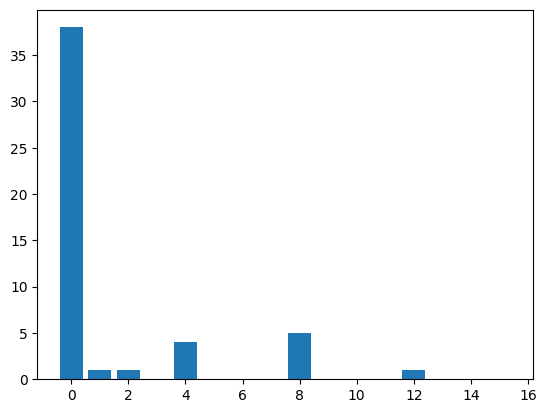

In [265]:
plt.bar(range(16), list(countsQW_t[0].values()))

In [311]:
countsQW_t[2] = list(SummingDict(countsQW_t[2]).values())
countsQW_t[4] = list(SummingDict(countsQW_t[4]).values())
countsQW_t[6] = list(SummingDict(countsQW_t[6]).values())
countsQW_t[8] = list(SummingDict(countsQW_t[8]).values())

KeyError: 21

In [312]:
totQW_counts_t = [countsQW_t[i] for i in range(0, T, 2)]

In [313]:
totQW_counts_t

[[38, 1, 1, 0, 4, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 0],
 [21, 0, 15, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 9, 0],
 [3, 0, 12, 0, 3, 0, 3, 0, 1, 1, 2, 0, 5, 0, 18, 2],
 [7, 0, 1, 0, 7, 0, 1, 1, 4, 0, 0, 0, 22, 1, 6, 0],
 [3, 1, 6, 0, 1, 0, 3, 0, 3, 1, 13, 2, 12, 1, 4, 0]]

In [276]:
totQW_counts_t[2]

[7, 0, 1, 0, 7, 0, 1, 1, 4, 0, 0, 0, 22, 1, 6, 0]

In [280]:
from matplotlib import pyplot as plt

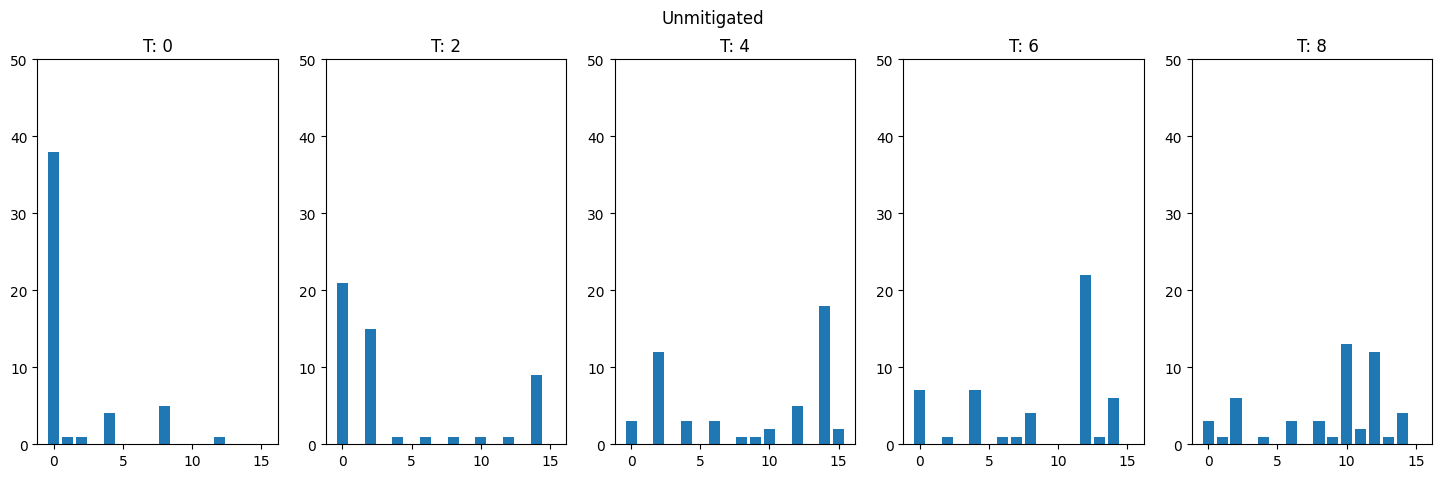

In [338]:
fig, axs = plt.subplots(1, len(totQW_counts_t), figsize=(18, 5))

for i,j in zip(range(len(totQW_counts_t)), range(0, 10, 2)):
    axs[i].bar(range(16), totQW_counts_t[i])
    axs[i].set_ylim(0, 50)
    axs[i].set_title(f"T: {j}")

plt.suptitle("Unmitigated")
plt.show()

In [292]:
Minv = linalg.inv(M / 50)

In [323]:
Qw_mitigated0, Qw_mitigated2, Qw_mitigated4, Qw_mitigated6, Qw_mitigated8 = Minv @ np.array(totQW_counts_t[0]).reshape(16, 1), Minv @ np.array(totQW_counts_t[1]).reshape(16, 1), Minv @ np.array(totQW_counts_t[2]).reshape(16, 1), Minv @ np.array(totQW_counts_t[3]).reshape(16, 1), Minv @ np.array(totQW_counts_t[4]).reshape(16, 1)

In [324]:
totQW_counts_tMitigated = [Qw_mitigated0.reshape(1, 16), Qw_mitigated2.reshape(1, 16), Qw_mitigated4.reshape(1, 16), Qw_mitigated6.reshape(1, 16),  Qw_mitigated8.reshape(1, 16)]

In [327]:
totQW_counts_tMitigated = np.abs(np.array(totQW_counts_tMitigated))

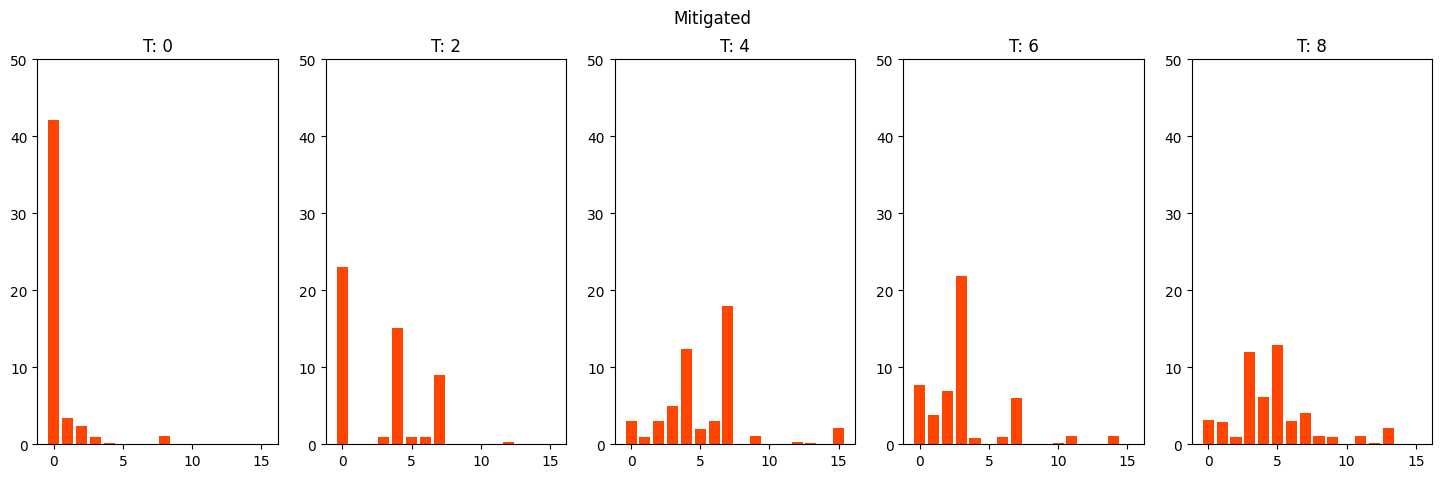

In [339]:
fig, axs = plt.subplots(1, len(totQW_counts_tMitigated), figsize=(18, 5))

for i,j in zip(range(len(totQW_counts_tMitigated)), range(0, 10, 2)):
    axs[i].bar(range(16), totQW_counts_tMitigated[i][0], color="orangered")
    axs[i].set_ylim(0, 50)
    axs[i].set_title(f"T: {j}")

plt.suptitle("Mitigated")
plt.show()